Knowledge Distillation is a process where a teacher model is trained, then a student model(of same or smaller size) is trained using teacher predictions. The loss function used is a combination of Kullback-Leibler divergence loss or distillation loss and CrossEntropy loss. Steps are as follows:

1. Train Teacher model normally.
2. Train Student model using custom distillation loss, difference of soft student predictions and soft teacher labels.
3. Results.

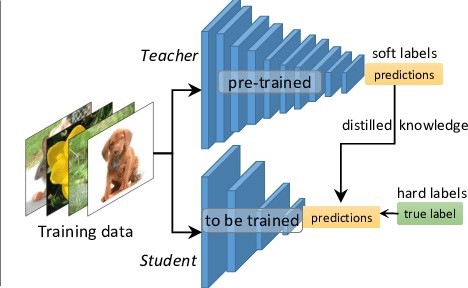

The Dataset used is tf flowers, it has 5 classes of flowers. 

## Imports

In [ ]:
import torch, os, cv2
from torch import nn
import torchvision
import numpy as np
import albumentations as A
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15,8)

seed = 2048
def seed_torch(seed=2021):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed)

In [ ]:
!pip install albumentations -U
A.__version__

'0.5.2'

## Download Dataset

In [ ]:
import tensorflow as tf

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
os.listdir(data_dir)

['LICENSE.txt', 'daisy', 'tulips', 'sunflowers', 'dandelion', 'roses']

In [ ]:
p1 = "/root/.keras/datasets/flower_photos/tulips/"
p2 = "/root/.keras/datasets/flower_photos/daisy/"
p3 = "/root/.keras/datasets/flower_photos/sunflowers/"
p4 = "/root/.keras/datasets/flower_photos/roses/"
p5 = "/root/.keras/datasets/flower_photos/dandelion/"

## Show sample 

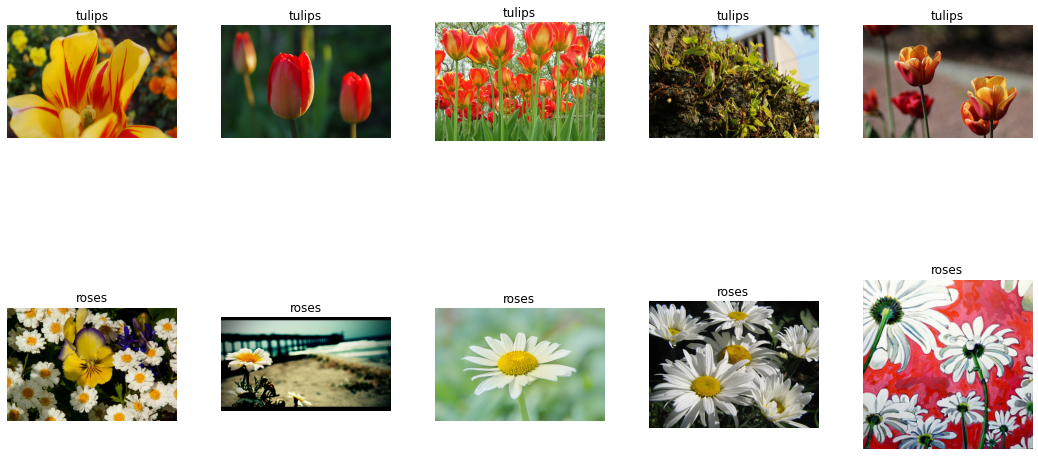

In [ ]:
# sample some images

sample_imgs = [p1+i for i in os.listdir(p1)[:5]]
sample_imgs = sample_imgs + [p2+j for j in os.listdir(p2)[:5]]
sample_labels = ["tulips"]*5 + ["roses"]*5

r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    im = cv2.imread(sample_imgs[a])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    axs[i,j].imshow(im)
    axs[i,j].set_title(sample_labels[a])
    axs[i,j].axis('off')
    a+=1

## Prepare Dataset

In [ ]:
class MakeDataset(Dataset):
    def __init__(self,images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform  = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx]).long()
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # image = self.transform(image)   
        augmented = self.transform(image=image) # for albumentation
        image = augmented['image']

        return image, label    

In [ ]:
# split dataset

images_dirs = [p1, p2, p3, p4, p5]
all_images = []
labels = []
for id, img_dir in enumerate(images_dirs):
  for i in os.listdir(img_dir):
      all_images.append(img_dir+i)
      labels.append(id)

X_train, X_test, Y_train, Y_test = train_test_split(all_images, labels, test_size= 0.3)

print('Total Train samples:', len(Y_train))
print('Total Test samples:', len(Y_test))    

Total Train samples: 2569
Total Test samples: 1101


## Data augumentations

In [ ]:
batch_size = 128

from albumentations.pytorch import ToTensorV2

transforms_train = A.Compose([
   A.HorizontalFlip(p=0.5),
  A.Resize(224, 224),
  A.Normalize(),
  ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(p=1.0),
])

train_dataset = MakeDataset(X_train, Y_train, transform=transforms_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)

val_dataset = MakeDataset(X_test, Y_test, transform=transforms_valid)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
val_dataset[0][0].shape

torch.Size([3, 224, 224])

## Prepare models

In [ ]:
teacher = models.resnet18(pretrained=True).cuda(0)
teacher.fc = torch.nn.Linear(in_features=512, out_features=10).cuda(0)

student = models.resnet18(pretrained=True).cuda(0)
student.fc = torch.nn.Linear(in_features=512, out_features=10).cuda(0)

## Trainer functions

In [ ]:
def teacher_one_epoch(train_loader):
    teacher.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to('cuda'), targets.to('cuda')
        outputs = teacher(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
    return running_loss

def student_one_epoch(train_loader):
    teacher.eval()
    student.train()
    softmax = nn.Softmax(dim=1)
    distil_loss = 0.0
    stud_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to('cuda'), targets.to('cuda')
        with torch.no_grad():
          teacher_outputs = teacher(images)
        student_outputs = student(images)
        student_loss = criterion(student_outputs, targets) # cross entropy loss
        distillation_loss = distil_criterion(softmax(teacher_outputs/temperature),
                                  softmax(student_outputs/temperature)) # distill loss
        loss = alpha * student_loss + (1 - alpha) * distillation_loss # combination of both
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad()
        stud_loss += student_loss.item()
        distil_loss += distillation_loss.item()
    return stud_loss, distil_loss

def val_one_epoch(model, valid_loader):
    model.eval()
    running_loss = 0.0
    correct = 0.0

    for images, targets in valid_loader:
        images, targets = images.to('cuda'), targets.to('cuda')
        with torch.no_grad(): 
            outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item()    
        _, outputs = torch.max(outputs,1)
        correct += torch.eq(outputs, targets).sum().item()
    return running_loss, correct

## Train Teacher model

In [ ]:
%%time 

LR = 0.0003
EPOCHS = 5
MAX_SCORE = 50.0
optimizer = torch.optim.Adam(teacher.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-7)
criterion = torch.nn.CrossEntropyLoss()

TRAIN_STEP = len(train_dataset)/batch_size
VALID_STEP = len(val_dataset)/batch_size
model_save_path = 'teacher_model.bin'

TRAIN_LOSS = []
VAL_LOSS = []
VAL_ACC = []

for epoch in range(1, EPOCHS+1):

  print("Epoch", epoch)
  train_l = teacher_one_epoch(train_loader)
  train_l = train_l/TRAIN_STEP
  TRAIN_LOSS.append(train_l)
  print("Training loss:", train_l)

  valid_l, correct = val_one_epoch(teacher, val_loader)
  valid_l = valid_l/VALID_STEP
  print("Valid loss:", valid_l)
  VAL_LOSS.append(valid_l)

  valid_a = (correct / len(val_dataset)) * 100
  print('Valid Accuracy: %d %%' % valid_a)
  VAL_ACC.append(valid_a)

  scheduler.step()

  if MAX_SCORE < valid_a:
      MAX_SCORE = valid_a
      torch.save({
                'model_state_dict': teacher.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'schduler': scheduler.state_dict()
                }, model_save_path)
      print('Model Saved...')
  print('')   
print("Best accuracy:", valid_a)  

Epoch 1
Training loss: 0.5461064112608699
Valid loss: 0.6007792674661441
Valid Accuracy: 85 %
Model Saved...

Epoch 2
Training loss: 0.1447495384038121
Valid loss: 0.2466765359571909
Valid Accuracy: 92 %
Model Saved...

Epoch 3
Training loss: 0.06652499572364863
Valid loss: 0.23852368596464152
Valid Accuracy: 91 %

Epoch 4
Training loss: 0.03420528626803899
Valid loss: 0.2013534836938011
Valid Accuracy: 93 %
Model Saved...

Epoch 5
Training loss: 0.037389934480584704
Valid loss: 0.18811210472945405
Valid Accuracy: 93 %

Best accuracy: 93.2788374205268
CPU times: user 20.1 s, sys: 17.4 s, total: 37.4 s
Wall time: 1min 26s


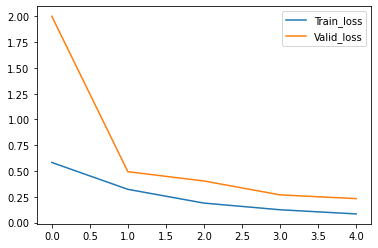

In [ ]:
# draw graph for train and valid loss
plt.rcParams["figure.figsize"] = (6,4)

a = np.arange(0,EPOCHS)
plt.plot(a, TRAIN_LOSS, label="Train_loss")
plt.plot(a, VAL_LOSS, label="Valid_loss")
plt.legend()
plt.show()

# Train Student model

In [ ]:
%%time

LR = 0.0003
EPOCHS = 5
MAX_SCORE = 50.0
optimizer = torch.optim.Adam(student.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-7)
criterion = torch.nn.CrossEntropyLoss()
distil_criterion = torch.nn.KLDivLoss()
alpha=0.1 # loss weight 
temperature=10 

TRAIN_STEP = len(train_dataset)/batch_size
VALID_STEP = len(val_dataset)/batch_size
model_save_path = 'student_model.bin'

TRAIN_LOSS = []
VAL_LOSS = []
VAL_ACC = []

for epoch in range(1, EPOCHS+1):

  print("Epoch", epoch)
  train_l, distil_l = student_one_epoch(train_loader)
  train_l = train_l/TRAIN_STEP
  distil_l = distil_l/TRAIN_STEP
  TRAIN_LOSS.append(train_l)
  print("Training loss:", train_l)
  print("Distillation loss:", distil_l)

  valid_l, correct = val_one_epoch(student, val_loader)
  valid_l = valid_l/VALID_STEP
  print("Valid loss:", valid_l)
  VAL_LOSS.append(valid_l)

  valid_a = (correct / len(val_dataset)) * 100
  print('Valid Accuracy: %d %%' % valid_a)
  VAL_ACC.append(valid_a)

  scheduler.step()

  if MAX_SCORE < valid_a:
      MAX_SCORE = valid_a
      torch.save({
                'model_state_dict': student.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'schduler': scheduler.state_dict()
                }, model_save_path)
      print('Model Saved...')
  print('')   
print("Best accuracy:", valid_a)    

Epoch 1
Training loss: 0.5368854965204022
Distillation loss: -0.24895281140188988
Valid loss: 0.48278541807474384
Valid Accuracy: 86 %
Model Saved...

Epoch 2
Training loss: 0.11608306384355746
Distillation loss: -0.24743631332474675
Valid loss: 0.2592652067068379
Valid Accuracy: 92 %
Model Saved...

Epoch 3
Training loss: 0.0791397153194334
Distillation loss: -0.24754946980786352
Valid loss: 0.2259004845822756
Valid Accuracy: 92 %
Model Saved...

Epoch 4
Training loss: 0.05443738457199756
Distillation loss: -0.24778962051789555
Valid loss: 0.2038606908730655
Valid Accuracy: 93 %
Model Saved...

Epoch 5
Training loss: 0.05756757077469163
Distillation loss: -0.24798235256600445
Valid loss: 0.18314742868754347
Valid Accuracy: 94 %
Model Saved...

Best accuracy: 94.09627611262489
CPU times: user 28.4 s, sys: 25.2 s, total: 53.5 s
Wall time: 1min 40s


Reference: https://keras.io/examples/vision/knowledge_distillation/